In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import numpy as np

import GPyOpt

import argparse

from utils import tf_config, preprocess_data, search_algorithms, train, losses_utils, metrics

from models import fmri_ae, eeg_to_fmri, uniconv_fmri

from layers import locally_connected

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

import time

dataset="01"
memory_limit=1500
n_individuals=10
interval_eeg=10

tf_config.set_seed(seed=42)
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

with tf.device('/CPU:0'):
    train_data, _ = preprocess_data.dataset(dataset, n_individuals=n_individuals,
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=False,
                                            standardize_fmri=True,
                                            iqr=False,
                                            verbose=True)
    eeg_train, fmri_train =train_data

I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


In [2]:
eeg_train = eeg_train[:100]
fmri_train = fmri_train[:100]

## Build fMRI AE

In [3]:
theta = (0.002980911194116198, 0.0004396489214334123, (9, 9, 4), (1, 1, 1), 4, (7, 7, 7), 4, True, True, True, True, 3, 1)

In [4]:
#unroll hyperparameters
learning_rate=float(theta[0])
weight_decay = float(theta[1])
kernel_size = theta[2]
stride_size = theta[3]
batch_size=int(theta[4])
latent_dimension=theta[5]
n_channels=int(theta[6])
max_pool=bool(theta[7])
batch_norm=bool(theta[8])
skip_connections=bool(theta[9])
dropout=bool(theta[10])
n_stacks=int(theta[11])
outfilter=int(theta[12])
local=True

In [5]:
na_specification = ([(10,20,2),(10,20,2)], 
                    [(1,1,1),(1,1,1)],
                   True,
                   (2,2,1),
                   (1,1,1))

In [6]:
with tf.device('/CPU:0'):
    model = eeg_to_fmri.EEG_to_fMRI(latent_dimension, eeg_train.shape[1:], na_specification, 4,
                        weight_decay=0.000, skip_connections=True,
                        batch_norm=True, #dropout=False,
                        local=True, seed=None, 
                        fmri_args = (latent_dimension, fmri_train.shape[1:], 
                        kernel_size, stride_size, n_channels, 
                        max_pool, batch_norm, weight_decay, skip_connections,
                        n_stacks, True, False, outfilter, dropout))
    
    model.build(eeg_train.shape, fmri_train.shape)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    loss_fn = losses_utils.mse_cosine

    train_set = tf.data.Dataset.from_tensor_slices((eeg_train, fmri_train)).batch(batch_size)
    dev_set= tf.data.Dataset.from_tensor_slices((eeg_train, fmri_train)).batch(1)

In [7]:
loss_history = train.train(train_set, model, optimizer, 
                            loss_fn, epochs=10, 
                            u_architecture=True,
                            val_set=dev_set, verbose=True, verbose_batch=True)[0]

Batch ... with loss: 1.4938496
Batch ... with loss: 1.1354897
Batch ... with loss: 1.0092928
Batch ... with loss: 1.0266868
Batch ... with loss: 0.90795255
Batch ... with loss: 0.94393885
Batch ... with loss: 0.938016
Batch ... with loss: 0.91441596
Batch ... with loss: 0.8897809
Batch ... with loss: 0.90264326
Batch ... with loss: 0.90456986
Batch ... with loss: 0.87911236
Batch ... with loss: 0.8721726
Batch ... with loss: 0.85789645
Batch ... with loss: 0.85682625
Batch ... with loss: 0.8532547
Batch ... with loss: 0.8636235
Batch ... with loss: 0.8668444
Batch ... with loss: 0.8741275
Batch ... with loss: 0.85209537
Batch ... with loss: 0.8493446
Batch ... with loss: 0.8529239
Batch ... with loss: 0.84426165
Batch ... with loss: 0.84259
Batch ... with loss: 0.8369355
Epoch 1 with loss: 0.9227458047866821
Batch ... with loss: 0.8445691
Batch ... with loss: 0.842592
Batch ... with loss: 0.840597
Batch ... with loss: 0.86087763
Batch ... with loss: 0.8418426
Batch ... with loss: 0.840

In [11]:
for instance_x, instance_y in dev_set.repeat(1):
    print(losses_utils.mse(instance_y, model([instance_x, instance_y])[0]))

tf.Tensor([[0.00413378]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00396659]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00404678]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00393612]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00434121]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00447215]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00429374]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00448676]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00539835]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00557459]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00626497]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00629282]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00638911]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00584847]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00549298]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00512138]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00525426]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.00460104]], shape=(1, 1), dtype=float32)
tf.Tensor(

## Prediction vs ground truth plot

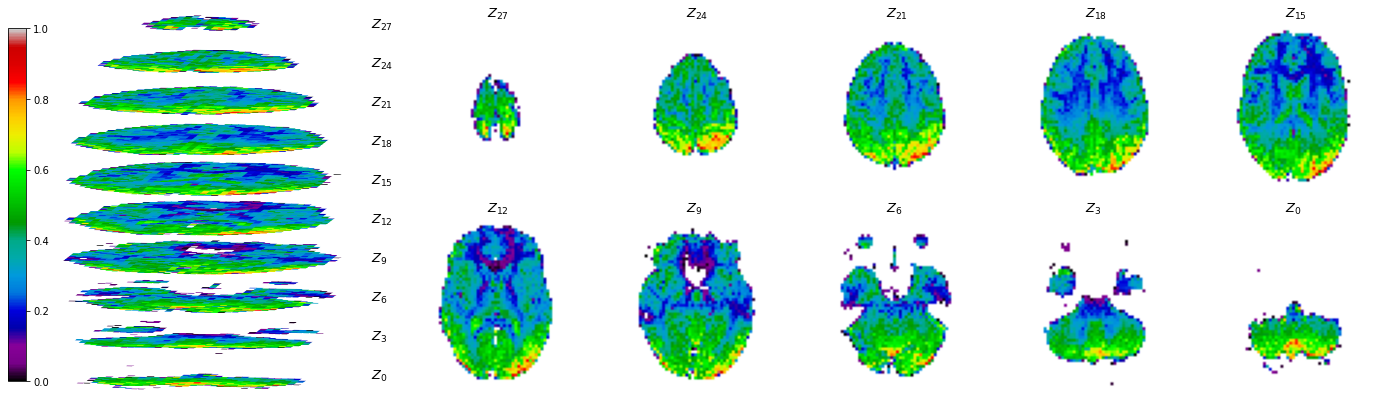

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


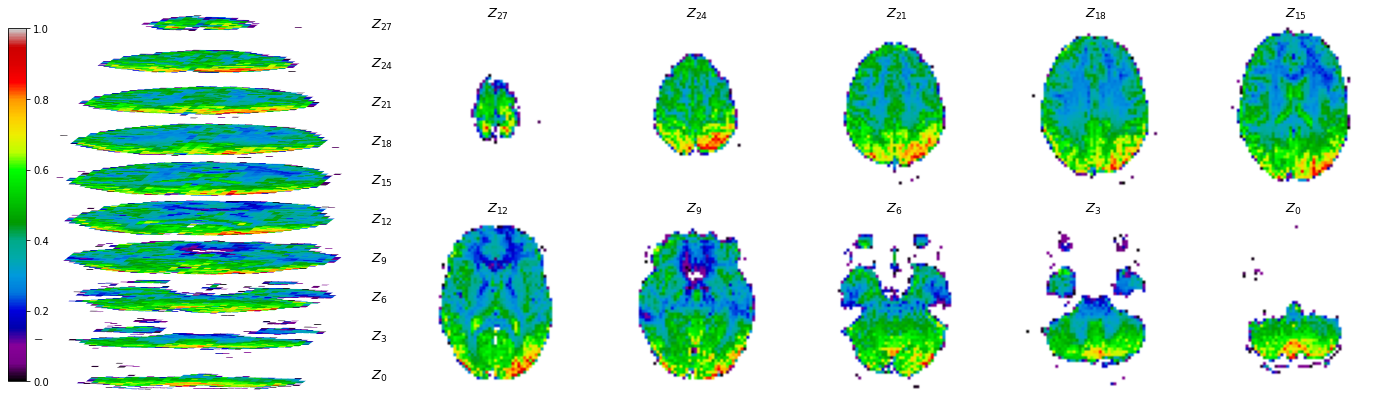

In [9]:
from utils import viz_utils

save_path = "/home/ist_davidcalhas/eeg_to_fmri/plots/100_instances/"
plot_format="png"

instance = 1
for instance_x, instance_y in dev_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(instance_y.numpy()[0])
    #plt.savefig(save_path + str(instance) + "_ground_truth."+plot_format, format=plot_format)
    fig.show()
    
    fig = viz_utils.plot_3D_representation_projected_slices(model([instance_x, instance_y])[0].numpy()[0])
    #plt.savefig(save_path + str(instance) + "_predicted."+plot_format, format=plot_format)
    fig.show()
    instance += 1
    break

## Structural Similarity Index

In [12]:
metrics.ssim(dev_set, model)

0.8806825564503669